# Evaluation

In [68]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [10, 7]
plt.style.use('seaborn-v0_8')

import seaborn as sns
sns.set(style="darkgrid")

import numpy as np 
import pandas as pd 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Constants

In [69]:
PROJECT_ROOT = Path("__file__").resolve().parents[1]

DATA_DPATH = PROJECT_ROOT / "data"
assert DATA_DPATH.exists()

PREDICTION_DPATH = DATA_DPATH / "predictions"
assert PREDICTION_DPATH.exists()

## Data Loading 

In [70]:
train_fpath = DATA_DPATH / "datasets" / "train.csv"

train_df = pd.read_csv(train_fpath).set_index("timestamp")
train_df.shape

(790, 2)

## Prediction Loading 

In [71]:
holt_winters_fpath = PREDICTION_DPATH / "holt_winters_predictions.csv"
holt_winters_pred_df = pd.read_csv(holt_winters_fpath, index_col=0).set_index("timestamp")
print(f"Holt Winters Data Shape: {holt_winters_pred_df.shape}")

linear_reg_fpath = PREDICTION_DPATH / "linear_regression_predictions.csv"
linear_reg_pred_df = pd.read_csv(linear_reg_fpath).set_index("timestamp")
print(f"Linear Regression Data Shape: {linear_reg_pred_df.shape}")

lgbm_fpath = PREDICTION_DPATH / "lgbm_predictions.csv"
lgbm_pred_df = pd.read_csv(lgbm_fpath).set_index("timestamp")
print(f"LGBM Data Shape: {lgbm_pred_df.shape}")

Holt Winters Data Shape: (30, 2)
Linear Regression Data Shape: (30, 2)
LGBM Data Shape: (30, 2)


## Metric Functions

In [72]:
def calculate_error(preds_df):
    # MAE, MSE, RMSE
    preds_df["error"] = preds_df["y_pred"] - preds_df["y_test"]
    preds_df["abs_error"] = np.abs(preds_df["error"])
    preds_df["sq_error"] = np.power(preds_df["error"], 2)

    preds_df["abs_error_weighted"] = np.where(preds_df["error"] < 0, 2 * np.abs(preds_df["error"]), np.abs(preds_df["error"]))
    preds_df["sq_error_weighted"] = np.where(preds_df["error"] < 0, np.power(2 * preds_df["error"], 2), np.power(preds_df["error"], 2))

    # MPE, MAPE
    preds_df["y_test_pe"] = preds_df["y_test"]
    preds_df.loc[preds_df["y_test_pe"] == 0, "y_test_pe"] = np.nan
    preds_df["perc_error"] = (preds_df["y_test_pe"] - preds_df["y_pred"]) / preds_df["y_test_pe"] * 100
    preds_df["abs_perc_error"] = preds_df["perc_error"].abs()


    preds_df["sym_abs_perc_error"] = (
        (preds_df["y_test_pe"] - preds_df["y_pred"]).abs() 
        / ((preds_df["y_test_pe"].abs() + preds_df["y_pred"].abs()) / 2)
    ) * 100

    preds_df = preds_df.drop(columns=["y_test_pe"])

    return preds_df


def calculate_metrics(preds_df):
    metrics_df = (
        preds_df
        .agg(
            {
                "abs_error": "mean", 
                "sq_error": "mean",
                "abs_error_weighted": "mean", 
                "sq_error_weighted": "mean",
                "perc_error": "mean", 
                "abs_perc_error": "mean",
                "sym_abs_perc_error": "mean",
            }
        )
        .reset_index()
    )
    metrics_df = pd.pivot_table(metrics_df, columns="index")
    metrics_df = metrics_df.rename(
        columns={
            "abs_error": "MAE",
            "sq_error": "MSE",
            "abs_error_weighted": "wMAE", 
            "sq_error_weighted": "wMSE",
            "perc_error": "MPE",
            "abs_perc_error": "MAPE",
            "sym_abs_perc_error": "SMAPE",
        }
    )
    metrics_df.columns.name = ""

    metrics_df["RMSE"] = np.sqrt(metrics_df["MSE"])
    metrics_df["wRMSE"] = np.sqrt(metrics_df["wMSE"])

    return metrics_df

## Metrics

In [73]:
holt_winters_errors = calculate_error(holt_winters_pred_df)
holt_winter_metrics = calculate_metrics(holt_winters_errors)
holt_winter_metrics["model"] = "holt_winters"

linear_reg_errors = calculate_error(linear_reg_pred_df)
linear_reg_metrics = calculate_metrics(linear_reg_errors)
linear_reg_metrics["model"] = "linear_reg"

lgbm_errors = calculate_error(lgbm_pred_df)
lgbm_metrics = calculate_metrics(lgbm_errors)
lgbm_metrics["model"] = "lgbm"

metrics_df = pd.concat((holt_winter_metrics, linear_reg_metrics, lgbm_metrics))

metrics_df.sort_values("MAE")

,MAE,wMAE,MAPE,MPE,MSE,wMSE,SMAPE,RMSE,wRMSE,model
0,174.813214,245.458787,69.153332,-49.032814,42255.912911,87461.379236,38.964611,205.562431,295.738701,holt_winters
0,190.745774,304.114346,67.134749,-31.416639,55836.896092,156423.420862,43.229911,236.298320,395.504009,lgbm
0,213.352289,274.853781,83.618467,-66.172201,68489.467538,109626.018995,43.524841,261.704925,331.098201,linear_reg


## Demo

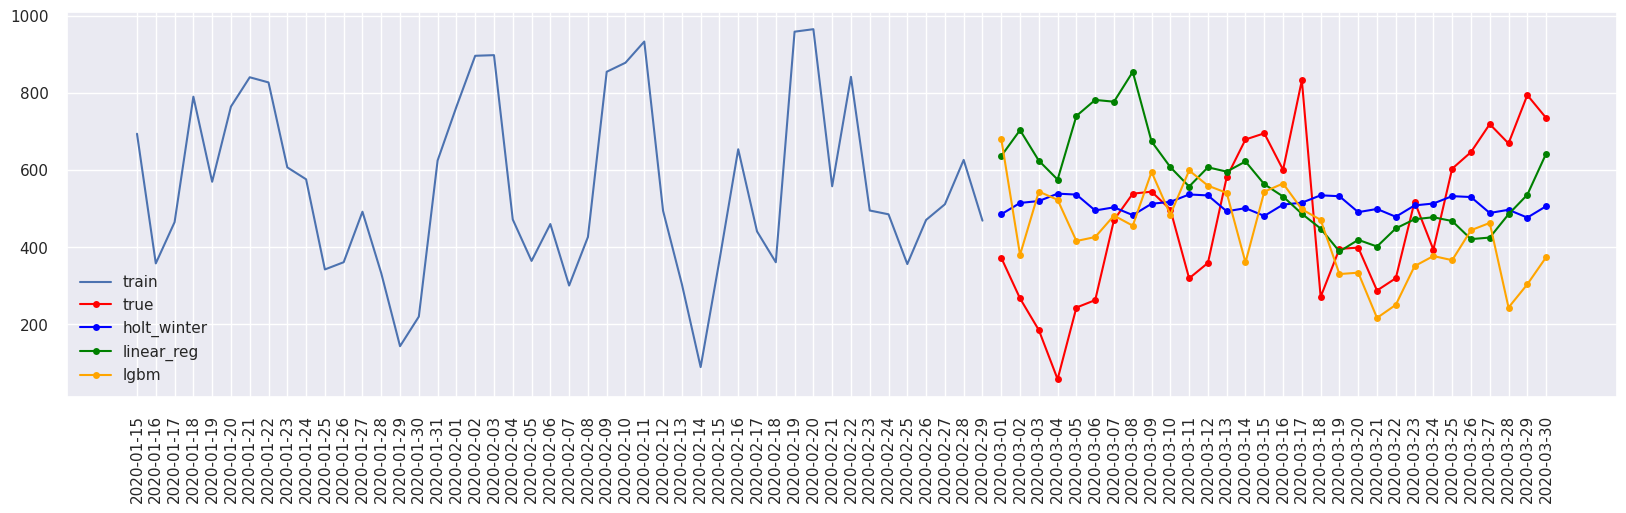

In [74]:
plt.figure(figsize=(20, 5))

ts_data = holt_winters_pred_df.index.values

train_plot_data = train_df.loc["2020-01-15":]
plt.plot(train_plot_data.index, train_plot_data["target"], label="train")

plt.plot(ts_data, holt_winters_pred_df["y_test"], ".-", color="red", label="true", markersize=10)
plt.plot(ts_data, holt_winters_pred_df["y_pred"], ".-", color="blue", label="holt_winter", markersize=10)
plt.plot(ts_data, linear_reg_pred_df["y_pred"], ".-", color="green", label="linear_reg", markersize=10)
plt.plot(ts_data, lgbm_pred_df["y_pred"], ".-", color="orange", label="lgbm", markersize=10)

plt.legend()
plt.xticks(rotation=90)

plt.show()